In [1]:
import torch
#torch.backends.mps.empty_cache()

In [2]:
#import all import libraries
import torch
import torchvision
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import datasets
from torch import optim
from torch.nn import Sequential
from torchvision.datasets import ImageFolder
from collections import OrderedDict
from torch import nn
import warnings
import cv2
from torch.autograd import Variable
from torchvision import models
import time
from PIL import Image
from sklearn.metrics import (
                            f1_score,
                            accuracy_score,
                            confusion_matrix,
                            classification_report,
                            )
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
RANDOM_SEED = 128
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu") 

In [ ]:
#load a single image for mean and standard deviation calculation
image = Image.open('../data/M9Project/seg_pred/seg_pred/10004.jpg')

In [27]:
transform = transforms.Compose([
    transforms.PILToTensor()
])
img_tensor = transform(image)

In [28]:
img_tensor = img_tensor / 255 #normalization of pixels
train_mean = img_tensor.reshape(3,-1).mean(axis=1)
train_std = img_tensor.reshape(3,-1).std(axis=1)

In [29]:
#create image transformers
train_transforms = transforms.Compose([transforms.Resize(150),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(150),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_mean, train_std)])
test_transforms = transforms.Compose([transforms.Resize(150),
                                      transforms.CenterCrop(150),
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_mean, train_std)])

In [30]:
#load train data
train_data = ImageFolder('../data/M9Project/seg_train/seg_train/', transform=train_transforms)

In [31]:
#load test data
test_data = ImageFolder('../data/M9Project/seg_test/',transform=test_transforms)

In [32]:
#check classes
train_data.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [33]:
#create a function to visualize the dataset
def img_show(images,normalize):
    sb.set_style("whitegrid")
    fig,index = plt.subplots(figsize=(15,10),ncols=5)
    if normalize:
        for i in range(5):
            image = images[i][0]
            image = image.numpy().transpose(1,2,0)
            std = 0.3
            mean = 0.2
            image = std*image + mean
            image = image.squeeze()
            index[i].set_xlabel([])
            index[i].set_ylabel([])
            plt.gray()
            index[i].grid(False)
            index[i].imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


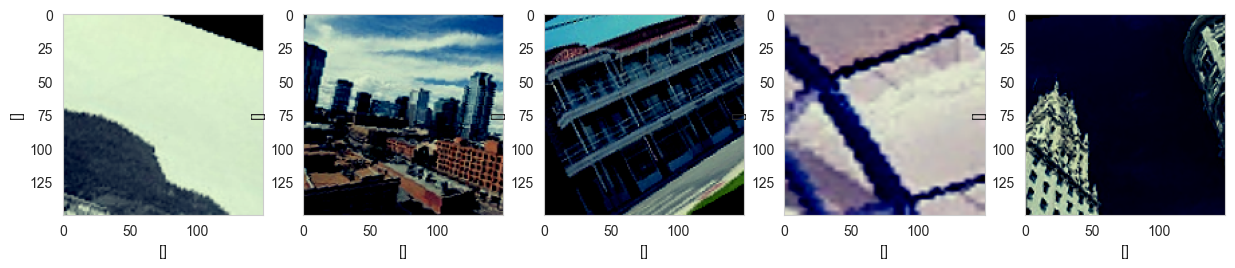

In [34]:
img_show(images=train_data,normalize=True)

In [35]:
#create the dataloaders 
trainloader = DataLoader(train_data,shuffle=True,batch_size=8,num_workers=5)
testloader = DataLoader(test_data,shuffle=True,batch_size=8,num_workers=5)

### Train ResNet 152

In [37]:
#download resnet 152 for transfer learing
model_resnet = models.resnet152(pretrained=True)
model_resnet 

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/nsoma/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [10:09<00:00, 397kB/s]    


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
#customize the output layer based on the number of classes we have
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,6)

In [39]:
#move the model to device
model = model_resnet.to(device)

In [40]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

In [41]:
images.shape

torch.Size([8, 3, 150, 150])

In [42]:
labels.shape

torch.Size([8])

In [43]:
#create  a criterion 
criterion = nn.CrossEntropyLoss().to(device)

In [44]:
#create an optimizer and learning rate updater
optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)
lr_sched = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.01)

In [45]:
#create a function to train and test the model
def training(model,optimizer,criterion,lr_sched,num_epoch):
  since = time.time()
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []
  for epoch in range(num_epoch):
    train_loss = 0 
    train_accuracy = 0
    for images, labels in trainloader:
      images = images.to(device)
      labels= labels.to(device)
      log_ps = model(images)
      optimizer.zero_grad()
      loss = criterion(log_ps,labels)
      proba = torch.exp(log_ps)
      topk_index,topk_classes = proba.topk(1,dim=1)
      equals = topk_classes == labels.view(topk_classes.shape)
      train_accuracy += torch.mean(equals.float()) 
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    else:
        model.eval()
        with torch.no_grad():
          test_loss = 0
          test_accuracy = 0
          for images, labels in testloader:
            images = images.to(device)
            labels= labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps,labels)
            proba = torch.exp(log_ps)
            topk_index,topk_classes = proba.topk(1,dim=1)
            equals = topk_classes == labels.view(topk_classes.shape)
            test_accuracy += torch.mean(equals.float()) 
            test_loss += loss.item() 
    model.train()
    train_losses.append(train_loss/len(trainloader))
    train_accuracies.append(train_accuracy/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    test_accuracies.append(test_accuracy/len(testloader))
    lr_sched.step()
    print('--'*10)        
    print("Epoch number is : {}/{} : ".format(epoch+1,num_epoch))
    print('-'*10)
    print("Train accuracy : {:.5f} ".format(train_accuracies[-1]),end=" | ")
    print("Test accuracy : {:.5f} ".format(test_accuracies[-1]))
  time_elapse = time.time() - since 
  print("Time taken for training : {:.0f}m : {:.0f}s : ".format(time_elapse//60,time_elapse%60))
  best_parameters = model.state_dict()
  torch.save(model.state_dict(),'../models/resnet_model_params.pth')
  torch.save(model,'../models/resnet_model.pth')
  return  model,best_parameters,train_losses,test_losses,train_accuracies,test_accuracies

In [46]:
model,best_params,train_losses,test_losses,train_accuracies,test_accuracies = training(model=model_resnet,
                                                                                       optimizer=optimizer,
                                                                                       criterion=criterion,
                                                                                       lr_sched=lr_sched,
                                                                                       num_epoch=20)

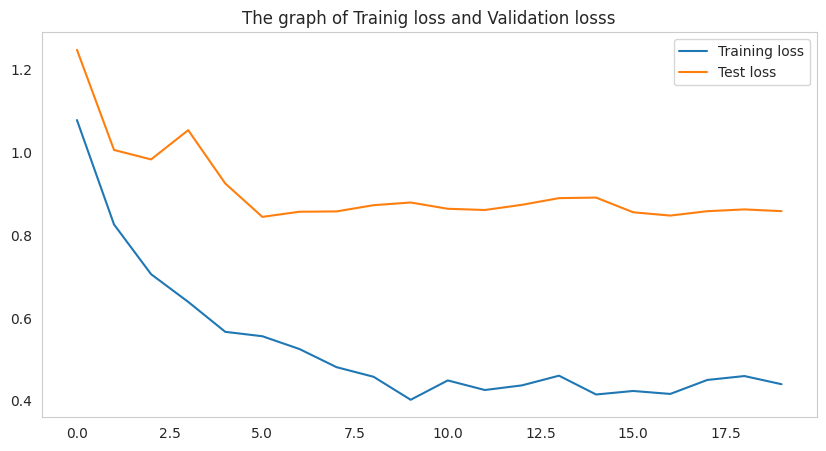

In [ ]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig loss and Validation losss | ResNet 152")
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Test loss")
plt.grid(False)
plt.legend()
plt.show()

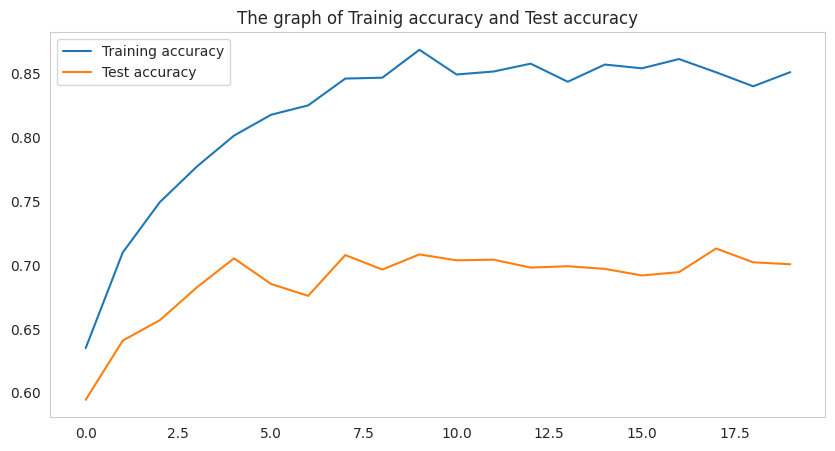

In [ ]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig accuracy and Test accuracy | ResNet 152")
plt.plot([i.to("cpu") for i in train_accuracies],label="Training accuracy")
plt.plot([i.to("cpu") for i in test_accuracies],label="Test accuracy")
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
valid_loader = DataLoader(test_data,shuffle=True,batch_size=54,num_workers=5)
dataiter_valid = iter(valid_loader)
images_valid,labels_valid = next(dataiter_valid)

In [ ]:
model.to("cpu").eval()
y_pred = model(images_valid)
y_pred_proba = torch.exp(y_pred)
topk_proba,topk_classes = y_pred_proba.topk(1,dim=1)

In [ ]:
cm = confusion_matrix(labels_valid.detach().numpy(), topk_classes.detach().numpy())
sb.set_style("whitegrid")
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix ")
sb.heatmap(cm,annot=True,cmap="Blues",cbar=False,annot_kws={"size":10},fmt="d")
plt.ylabel("Predicted Class")
plt.xlabel("Actual Class")
plt.show()

In [ ]:
#classification report
print(classification_report(labels_valid.detach().numpy(), topk_classes.detach().numpy()))
print("Accuracy Score : {:.2f}".format(accuracy_score(labels_valid.detach().numpy(), topk_classes.detach().numpy())))

In [ ]:
model.eval()
images,labels = next(iter(testloader))
actual_label = labels[4]
predicted_label = model(images[4].view(1,3,150,150))
label_proba = torch.exp(predicted_label)

In [ ]:
label_proba.shape

In [ ]:
topk_class,topk_idx = label_proba.topk(1,dim=1)

In [ ]:
print("Predicted class : ",topk_idx.item(),end=" | ")
print("Actual class : ",actual_label.item())

In [ ]:
import torch
torch.cuda.empty_cache()

### Train Inception V3

In [ ]:
model_inception_v3 = models.inception_v3(pretrained=True)
model_inception_v3

In [ ]:
model_inception_v3.aux_logits=False

In [ ]:
num_ftrs = model_inception_v3.fc.in_features
model_inception_v3.fc = nn.Linear(num_ftrs,7)

In [ ]:
model_inception_v3 = model_inception_v3.to(device)

In [ ]:
#create a function to train and test the model
def training(model,optimizer,criterion,lr_sched,num_epoch):
  since = time.time()
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []
  for epoch in range(num_epoch):
    train_loss = 0 
    train_accuracy = 0
    for images, labels in trainloader:
      images = images.to(device)
      labels= labels.to(device)
      log_ps = model(images)
      optimizer.zero_grad()
      loss = criterion(log_ps,labels)
      proba = torch.exp(log_ps)
      topk_index,topk_classes = proba.topk(1,dim=1)
      equals = topk_classes == labels.view(topk_classes.shape)
      train_accuracy += torch.mean(equals.float()) 
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    else:
        model.eval()
        with torch.no_grad():
          test_loss = 0
          test_accuracy = 0
          for images, labels in testloader:
            images = images.to(device)
            labels= labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps,labels)
            proba = torch.exp(log_ps)
            topk_index,topk_classes = proba.topk(1,dim=1)
            equals = topk_classes == labels.view(topk_classes.shape)
            test_accuracy += torch.mean(equals.float()) 
            test_loss += loss.item() 
    model.train()
    train_losses.append(train_loss/len(trainloader))
    train_accuracies.append(train_accuracy/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    test_accuracies.append(test_accuracy/len(testloader))
    lr_sched.step()
    print('--'*10)        
    print("Epoch number is : {}/{} : ".format(epoch+1,num_epoch))
    print('-'*10)
    print("Train accuracy : {:.5f} ".format(train_accuracies[-1]),end=" | ")
    print("Test accuracy : {:.5f} ".format(test_accuracies[-1]))
  time_elapse = time.time() - since 
  print("Time taken for training : {:.0f}m : {:.0f}s : ".format(time_elapse//60,time_elapse%60))
  best_parameters = model.state_dict()
  torch.save(model.state_dict(),'../models/inceptio_model_params.pth')
  torch.save(model,'../models/inception_model.pth')
  return  model,best_parameters,train_losses,test_losses,train_accuracies,test_accuracies

In [ ]:
model,best_params,train_losses,test_losses,train_accuracies,test_accuracies = training(model=model_inception_v3,
                                                                                       optimizer=optimizer,
                                                                                       criterion=criterion,
                                                                                       lr_sched=lr_sched,
                                                                                       num_epoch=20)

In [ ]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig loss and Validation losss | Inception")
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Test loss")
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig accuracy and Test accuracy | Inception")
plt.plot([i.to("cpu") for i in train_accuracies],label="Training accuracy")
plt.plot([i.to("cpu") for i in test_accuracies],label="Test accuracy")
plt.grid(False)
plt.legend()
plt.show()